# Import Libraries


In [ ]:
!pip install emoji

!pip install transformers

     |████████████████████████████████| 175 kB 5.2 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=640d817934f1f3d9dd89170004176fd52f5bda50adaac250b7a25bc098f7634f
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 3.8 MB 4.0 MB/s 
     |████████████████████████████████| 67 kB 1.9 MB/s 
     |████████████████████████████████| 895 kB 31.2 MB/s 
     |████████████████████████████████| 6.5 MB 13.4 MB/s 
     |████████████████████████████████| 596 kB 13.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd 

import numpy as np 

import seaborn as sns

import datetime

import matplotlib.pyplot as plt; plt.rcdefaults() 

import os #Nik
from sklearn.model_selection import train_test_split


import csv #Nik

import regex as re

# from langdetect import detect

import emoji

from transformers import RobertaTokenizer, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import transformers
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
device = torch.device('cuda')
from sklearn.metrics import f1_score
from transformers import AutoTokenizer,AutoModelForSequenceClassification

In [ ]:
#%% This is the dictionary of strings that should be replaced into a token useful for us
dict_tok_subs = {'<bitcn>':['bitc','Bitc','BITC','Btc','btc','BTC'], '<coin>':['#coin','coin','Coin','COIN'], '<address>':['Address', 'address', 'ADDRESS'], '<block>':['Blockchain', 'blockchain', 'BLOCKCHAIN', 'Block Chain', 'block chain', 'BLOCK CHAIN'], '<confirmation>': ['Confirmation', 'confirmation', 'CONFIRMATION'], '<cryptography>':['Cryptography', 'cryptography', 'CRYPTOGRAPHY'], '<doublespend>': ['doublespend', 'Doublespend', 'DOUBLESPEND', 'double spend', 'Double Spend', 'DOUBLE SPEND'],
                    '<hashrate>': ['Hash Rate', 'HASH RATE', 'hash rate'], '<mining>': ['MINING', 'mining', 'Mining'], '<p2p>' : ['p2p', 'P2P', 'peer-to-peer', 'Peer-to-peer'], '<privatekey>': ['Private Key', 'private key', 'PRIVATE KEY','privatekey', 'PRIVATEKEY', 'Privatekey'],
                    '<signature>':['SIGNATURE', 'Signature', 'signature'] , '<wallet>':['Wallet', 'WALLET', 'wallet'],
                 '<price>': ['price', 'PRICE', 'Price'], '<buy>': ['buy', 'BUY', 'Buy'], '<pump>': ['pump', 'PUMP', 'Pump'],
                 '<profit>': ['PROFIT', 'profit', 'Profit'], '<volume>': ['volume', 'Volume', 'VOLUME'],
                 '<etf>': ['ETF', 'etf', 'Etf'], '<bull>': ['bull', 'Bull', 'BULL'], '<sell>': ['sell', 'SELL', 'Sell'],
                 '<top>': ['top', 'TOP', 'Top'], '<win>': ['win', 'WIN', 'Win'], '<moon>': ['moon', 'MOON', 'Moon'],
                 '<signal>': ['signal', 'SIGNAL', 'Signal'], '<long>': ['long', 'LONG', 'Long'], '<chart>': ['CHART', 'chart', 'Chart'],
                 '<alts>': ['alts', 'ALTS', 'Alts'], '<hodl>': ['hodl', 'HODL', 'Hodl'], '<support>': ['support', 'SUPPORT', 'Support'],
                 '<short>': ['short', 'Short', 'SHORT'], '<drop>': ['drop', 'DROP', 'Drop'], '<project>': ['project', 'PROJECT', 'Project'],
                 '<bullish>': ['bulllish', 'Bullish', 'BULLISH'], '<fall>': ['fall', 'Fall', 'FALL'], '<dump>': ['dump', 'DUMP', 'Dump'],
                 '<bear>': ['bear', 'Bear', 'BEAR'], '<resistance>': ['resistance', 'RESISTANCE', 'Resistance'], '<opportunity>': ['opportunity', 'OPPORTUNITY', 'Opportunity'],
                 '<stop-loss>': ['stop-loss', 'stop loss', 'STOP-LOSS'], '<volume>': ['Volume', 'VOLUME', 'volume'],
                 '<chain>': ['chain', 'Chain', 'CHAIN'], '<hold>': ['hold', 'Hold', 'HOLD'], '<future>': ['future', 'FUTURE', 'Future'],
                 '<value>': ['value', 'Value', 'VALUE'], '<trader>': ['trader', 'Trader', 'TRADER'], '<nft>': ['nft', 'NFT', 'Nft'],
                 '<launch>': ['launch', 'Launch', 'LAUNCH'], '<fiat>': ['fiat', 'Fiat', 'FIAT'], '<liquid>': ['liquid', 'Liquid', 'LIQUID'],
                 '<scam>': ['scam', 'Scam', 'SCAM']}
                 
#%% Get the list of tokens that should be added
list_tokens = list(dict_tok_subs.keys())

In [ ]:
def convert_lists_to_tensors(tokens: transformers.tokenization_utils_base.BatchEncoding,
                             labels: pd.Series) -> list:
  """"
  Convert lists inside tokens to tensors
  """
  seq = torch.tensor(tokens['input_ids'])
  mask = torch.tensor(tokens['attention_mask'])
  y = labels.map({-1:[1,0,0],0:[0,1,0],1:[0,0,1]})
  y = torch.tensor(y.tolist(), dtype=torch.float)
  return seq, mask, y


def create_data_loader(seq: torch.tensor,
                       mask: torch.tensor,
                       y: torch.tensor,
                       batch_size: int=128) -> DataLoader:
  """
  Wrap all the tensor into a batched DataLoader
  """
  data = TensorDataset(seq, mask, y)
  ## sampler for sampling the data during training
  ## dataLoader for set
  #dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
  dataloader = DataLoader(data, shuffle=False, batch_size=batch_size)
  return dataloader


def tokenize_and_encode_sequences(tokenizer: transformers.PreTrainedTokenizerFast, 
                                  input_text: pd.Series, 
                                  max_length: int=128) -> transformers.tokenization_utils_base.BatchEncoding:
  """
  Tokenize and encode sequences in the input_text set  
  """
  tokens = tokenizer.batch_encode_plus(
      input_text.tolist(),
      padding='max_length',
      max_length = max_length,
      truncation=True,                 
      add_special_tokens = True, # Add '[CLS]' and '[SEP]'  
      return_attention_mask = True
  )
  return tokens

# Use this function on the list of normalized tweets to replace keyworks by other keywords (don't need to explain it too much)
# It will return a list of the tweets, which you can change into a pandas df afterwards
def replace_by_token(lst_of_tweets, tokens_dictionary):
  """_summary_
    In this function, words that are significant for bitcoin tweets are replaced
    by appropriate tokens.

    Parameters
    ----------
    input : list, dict
      The function takes as input a dataframe with 1 column of tweets
      and a dictionary with signifcant substrings of words which are assigned 
      to an appropriate token.
      The order in which the keys in the the dictionary are placed matters,
      as words that could be assigned to two different tokens will be replaced by 
      the token that shows up first in the dictionary.

    Returns
    -------
    output : list
      It returns a list of tweets in which the  significant words 
      of each tweet are replaced by tokens.
  """
  list_tweets = []
  #loop thourgh every tweet
  for text in lst_of_tweets:
    splits = text.split(" ")

    for split in range(len(splits)):
        #go to every toke
        for key in tokens_dictionary:
            #loop through substrings that are associated with each token
            for possible_string in tokens_dictionary[key]:
                if possible_string in splits[split]:
                    splits[split]=key

    text_tok = ' '.join(splits)
    list_tweets.append(text_tok)

  return list_tweets

# Import and Explore Datasets

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


##Import Dataset (KAGGLE Long Time Frame)

In [ ]:
dta_LT = pd.read_excel('/content/gdrive/My Drive/NLP Group Project (2022)/tweet_datasets/Kaggle_tweets_L_T_F_labelled.xlsx',index_col=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """Entry point for launching an IPython kernel.


In [ ]:
# Load the model and it's tokenizer
bertweet_retrained = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/My Drive/NLP Group Project (2022)/pre-training_fine-tuning_bertweet/bertweet-retrained",num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",additional_special_tokens =list_tokens)

Some weights of the model checkpoint at /content/gdrive/My Drive/NLP Group Project (2022)/bertweet-retrained were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/My Drive/NLP Group Project (2022)/bertweet-retrained and are newly initialized: ['classifier

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def bertweet_preprocess(text):
  res = tokenizer.normalizeTweet(text)
  return res

In [ ]:
dta_final = dta_LT.copy(True)
dta_final['clean_tweet'] = dta_final['text'].apply(bertweet_preprocess)

In [ ]:
dta_final.loc[dta_final['kind']=='project','sentiment'] = 0
dta_final.loc[dta_final['kind']=='ad','sentiment'] = 0
dta_final.loc[dta_final['kind']=='NFT','sentiment'] = 0
dta_final.loc[dta_final['kind']=='nft','sentiment'] = 0

EDA

In [ ]:
dta_final.sentiment.value_counts()

 0.0    1192
 1.0     848
-1.0     260
Name: sentiment, dtype: int64

**Resources used:** 
- https://huggingface.co/cardiffnlp/twitter-roberta-base
- https://github.com/Data-Science-kosta/Twitter-Sentiment-Analysis-RoBERTa/blob/main/SA_dataset1.ipynb



Pytorch DataSet

In [ ]:
# # example train test split
# train_text, test_text, train_labels, test_labels = train_test_split(dta_final['clean_tweet'], dta_final['sentiment'], 
#                                                                     random_state=1890, 
#                                                                     test_size=0.2, 
#                                                                     stratify=dta_final['sentiment'])

In [ ]:
# test_index = test_text.index
# valid_set = dta_final.loc[dta_final.index.isin(test_index)]
# valid_set.to_csv("/content/gdrive/My Drive/NLP Group Project (2022)/roberta_valid_set.csv")

In [ ]:
# train_index = train_text.index
# train_set = dta_final.loc[dta_final.index.isin(train_index)]
# train_set.to_csv("/content/gdrive/My Drive/NLP Group Project (2022)/roberta_train_set.csv")

In [ ]:
train_set = pd.read_csv("/content/gdrive/My Drive/NLP Group Project (2022)/tweet_datasets/roberta_train_set.csv",index_col=0)
valid_set = pd.read_csv("/content/gdrive/My Drive/NLP Group Project (2022)/tweet_datasets/roberta_valid_set.csv",index_col=0)
train_set['clean_tweet'] = train_set['text'].apply(bertweet_preprocess)
valid_set['clean_tweet'] = valid_set['text'].apply(bertweet_preprocess)

# train_text = train_set['clean_tweet']
# valid_text = valid_set['clean_tweet']
train_labels = train_set['sentiment']
valid_labels = valid_set['sentiment']

In [ ]:
train_set['bertweet_tweet'] = replace_by_token(train_set.clean_tweet.tolist(),dict_tok_subs)
valid_set['bertweet_tweet'] = replace_by_token(valid_set.clean_tweet.tolist(),dict_tok_subs)
train_text = train_set['bertweet_tweet']
valid_text = valid_set['bertweet_tweet']

In [ ]:
max_length = 64
batch_size = 32

tokens_train = tokenize_and_encode_sequences(tokenizer,
                                             train_text,
                                             max_length=max_length)
tokens_valid = tokenize_and_encode_sequences(tokenizer,
                                            valid_text,
                                            max_length=max_length)

In [ ]:
# compute class weight for training with imbalanced dataset
cws = compute_class_weight(class_weight='balanced',classes=np.unique(train_labels),y=train_labels)
print(cws)

class_weights = torch.tensor(cws).to(device)

[2.89644013 0.64714389 0.90130916]


In [ ]:
train_seq, train_mask, train_y = convert_lists_to_tensors(tokens_train, train_labels)
valid_seq, valid_mask, valid_y = convert_lists_to_tensors(tokens_valid, valid_labels)

In [ ]:
train_dataloader = create_data_loader(train_seq, train_mask, train_y, batch_size=batch_size)
valid_dataloader = create_data_loader(valid_seq, valid_mask, valid_y, batch_size=batch_size)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/My Drive/NLP Group Project (2022)/bertweet-retrained", #
                                                      num_labels = 3,
                                                      output_attentions = False,
                                                      output_hidden_states = False,
                                                      problem_type="multi_label_classification"
)

model.cuda()
model.to(device)

Some weights of the model checkpoint at /content/gdrive/My Drive/NLP Group Project (2022)/bertweet-retrained were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/My Drive/NLP Group Project (2022)/bertweet-retrained and are newly initialized: ['classifier

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64051, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 3e-6)# learning rate
epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_default(class_weights):
  """
  Train Created Model
  """
  model.train()
  #print(model.name)
  total_loss = 0
  # empty list to save model predictions
  total_preds=[]
  true_labels_list = []
  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # push the batch to gpu|
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    outputs = model(sent_id, 
                      token_type_ids=None, 
                      attention_mask=mask, 
                      labels=labels,
                      return_dict=True)

    logits = outputs['logits']
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    loss = criterion(logits,labels)

    total_loss = total_loss + loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(),  max_norm=1.0)
    optimizer.step()

    scheduler.step()
    preds = logits.detach().cpu()
    total_preds.append(preds)
    true_labels_list.append(labels)

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    
  avg_loss = total_loss / len(train_dataloader)
  train_preds = torch.cat(total_preds).detach().cpu()
  
  m = nn.Softmax(dim=1)
  output = m(train_preds)
  train_labels = torch.cat(true_labels_list).detach().cpu().numpy()
  true_y = train_labels.argmax(axis=1) - 1
  pred_y = output.argmax(axis=1) - 1
  train_f1_score = f1_score(true_y, pred_y ,average=None)
  print("Training F1 score",train_f1_score)

  return avg_loss


In [ ]:
# function for evaluating the model
def evaluate_epoch(class_weights):
  
  print("\nEvaluating...")
  model.eval()

  total_loss = 0
  total_preds = []
  true_labels_list = []

  with torch.no_grad():
    for step,batch in enumerate(valid_dataloader):     
      batch = [t.to(device) for t in batch]
      sent_id, mask, labels = batch
      # deactivate autograd
      
      outputs = model(sent_id, 
                      token_type_ids=None, 
                      attention_mask=mask, 
                      labels=labels,
                      return_dict=True)

      logits = outputs['logits']
      criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
      loss = criterion(logits,labels)
      preds = logits.detach().cpu()
      total_preds.append(preds)
      true_labels_list.append(labels)

      # total_preds.append(preds)
      total_loss = total_loss + loss.item()
      avg_loss = total_loss / len(valid_dataloader)
    test_preds = torch.cat(total_preds).detach().cpu()
    m = nn.Softmax(dim=1)
    output = m(test_preds)
    valid_labels = torch.cat(true_labels_list).detach().cpu().numpy()
    true_y = valid_labels.argmax(axis=1) - 1
    pred_y = output.argmax(axis=1) - 1
    valid_f1_score = f1_score(true_y, pred_y ,average=None)
    print("Validation F1 score",valid_f1_score)

  return avg_loss

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses_bert=[]
valid_losses_bert=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss = train_default(class_weights)
    #evaluate model
    valid_loss = evaluate_epoch(class_weights)


    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "/content/gdrive/My Drive/NLP Group Project (2022)//pre-training_fine-tuning_bertweet/bertweet_for_classification2.pt")
    # append training and validation loss
    train_losses_bert.append(train_loss)
    valid_losses_bert.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')




 Epoch 1 / 20
  Batch    50  of     56.
Training F1 score [0.         0.60558101 0.20062048]

Evaluating...
Validation F1 score [0.         0.68041237 0.        ]

Training Loss: 1.116
Validation Loss: 1.078

 Epoch 2 / 20
  Batch    50  of     56.
Training F1 score [0.15503876 0.69207317 0.06303725]

Evaluating...
Validation F1 score [0.32941176 0.73646209 0.04651163]

Training Loss: 1.067
Validation Loss: 1.023

 Epoch 3 / 20
  Batch    50  of     56.
Training F1 score [0.35602094 0.74291027 0.24766355]

Evaluating...
Validation F1 score [0.35471698 0.75675676 0.17112299]

Training Loss: 1.003
Validation Loss: 0.955

 Epoch 4 / 20
  Batch    50  of     56.
Training F1 score [0.42352941 0.76275644 0.34573304]

Evaluating...
Validation F1 score [0.36434109 0.74883721 0.24038462]

Training Loss: 0.933
Validation Loss: 0.897

 Epoch 5 / 20
  Batch    50  of     56.
Training F1 score [0.4789916  0.77105832 0.48915187]

Evaluating...
Validation F1 score [0.39662447 0.73253012 0.3852459 ]


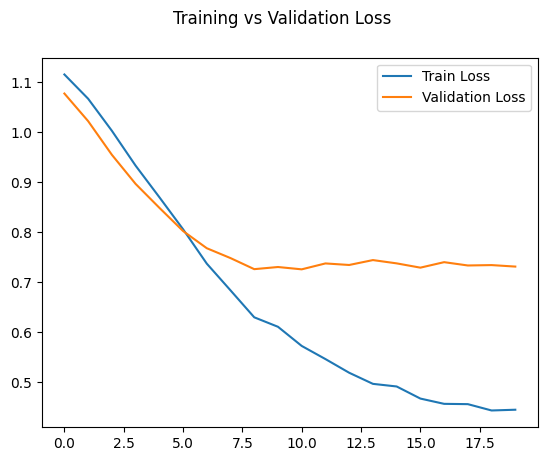

In [ ]:
plt.figure()
plt.plot(train_losses_bert,label='Train Loss')
plt.plot(valid_losses_bert,label='Validation Loss')
plt.legend()
plt.suptitle("Training vs Validation Loss")
plt.savefig("/content/gdrive/My Drive/NLP Group Project (2022)/pre-training_fine-tuning_bertweet/bertweet_loss_curve.png")